In [188]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
np.random.seed(32)
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import make_column_selector
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, precision_recall_curve, auc, f1_score, confusion_matrix, make_scorer, recall_score, precision_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

In [120]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [121]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

In [122]:
X_train.head()
len(X_train)

49000

In [114]:
# Custom SmokingImputer (Returns 2D output)
class SmokingImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.distribution_with_never = None
        self.distribution_without_never = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        self.distribution_without_never = X_df.loc[~X_df['smoking_history'].isin(['No Info', 'never']), 'smoking_history'].value_counts(normalize=True)
        self.distribution_with_never = X_df.loc[~X_df['smoking_history'].isin(['No Info']), 'smoking_history'].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        mask = X_df['smoking_history'] == 'No Info'
        X_df.loc[mask, 'smoking_history'] = np.random.choice(
            self.distribution_without_never.index, 
            size=mask.sum(), 
            p=self.distribution_without_never.values
        )
        return X_df[['smoking_history']].to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else ['smoking_history']

In [115]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        # Split and filter out empty sets or single-underscore terms
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        # Remove empty sets by converting to list of non-empty sets
        X_cleaned = [x for x in X_cleaned if x]
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

In [116]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

In [117]:
# HighCorrelationRemover with preserved feature names
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        self.to_keep_ = [True] * len(X_df.columns)
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > self.threshold and self.to_keep_[i]:
                    self.to_keep_[i] = False
        self.feature_names_out_ = [name for name, keep in zip(X_df.columns, self.to_keep_) if keep]
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.to_keep_]
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [123]:
# Define columns and encoders
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

# First preprocessor: Handle imputation and basic transformations
preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
        #('smokingImputer', SmokingImputer(), ['smoking_history']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

# Second preprocessor: Encode categorical variables with correct column names
preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

# Single pipeline combining all steps
pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95))
])

# Fit and transform training data
X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

# Transform test data
X_test_transformed = pipeline.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

# Print the final column names
print("Final column names for X_train_transformed_df:")
print(X_train_transformed_df.columns.tolist())
print(X_train_transformed_df.shape[1])

Final column names for X_train_transformed_df:
['genderEncoder__remainder__gender_Male', 'smokingEncoder__remainder__smoking_history_never', 'smokingEncoder__remainder__smoking_history_ever', 'smokingEncoder__remainder__smoking_history_current', 'smokingEncoder__remainder__smoking_history_not current', 'smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___consideration_for_metabolic_syndrome_and_type_2_diabetes', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___higher_predisposition_to_hypertension_and_diabetes', 'clinicalNotesBinarizer___history_of_hy

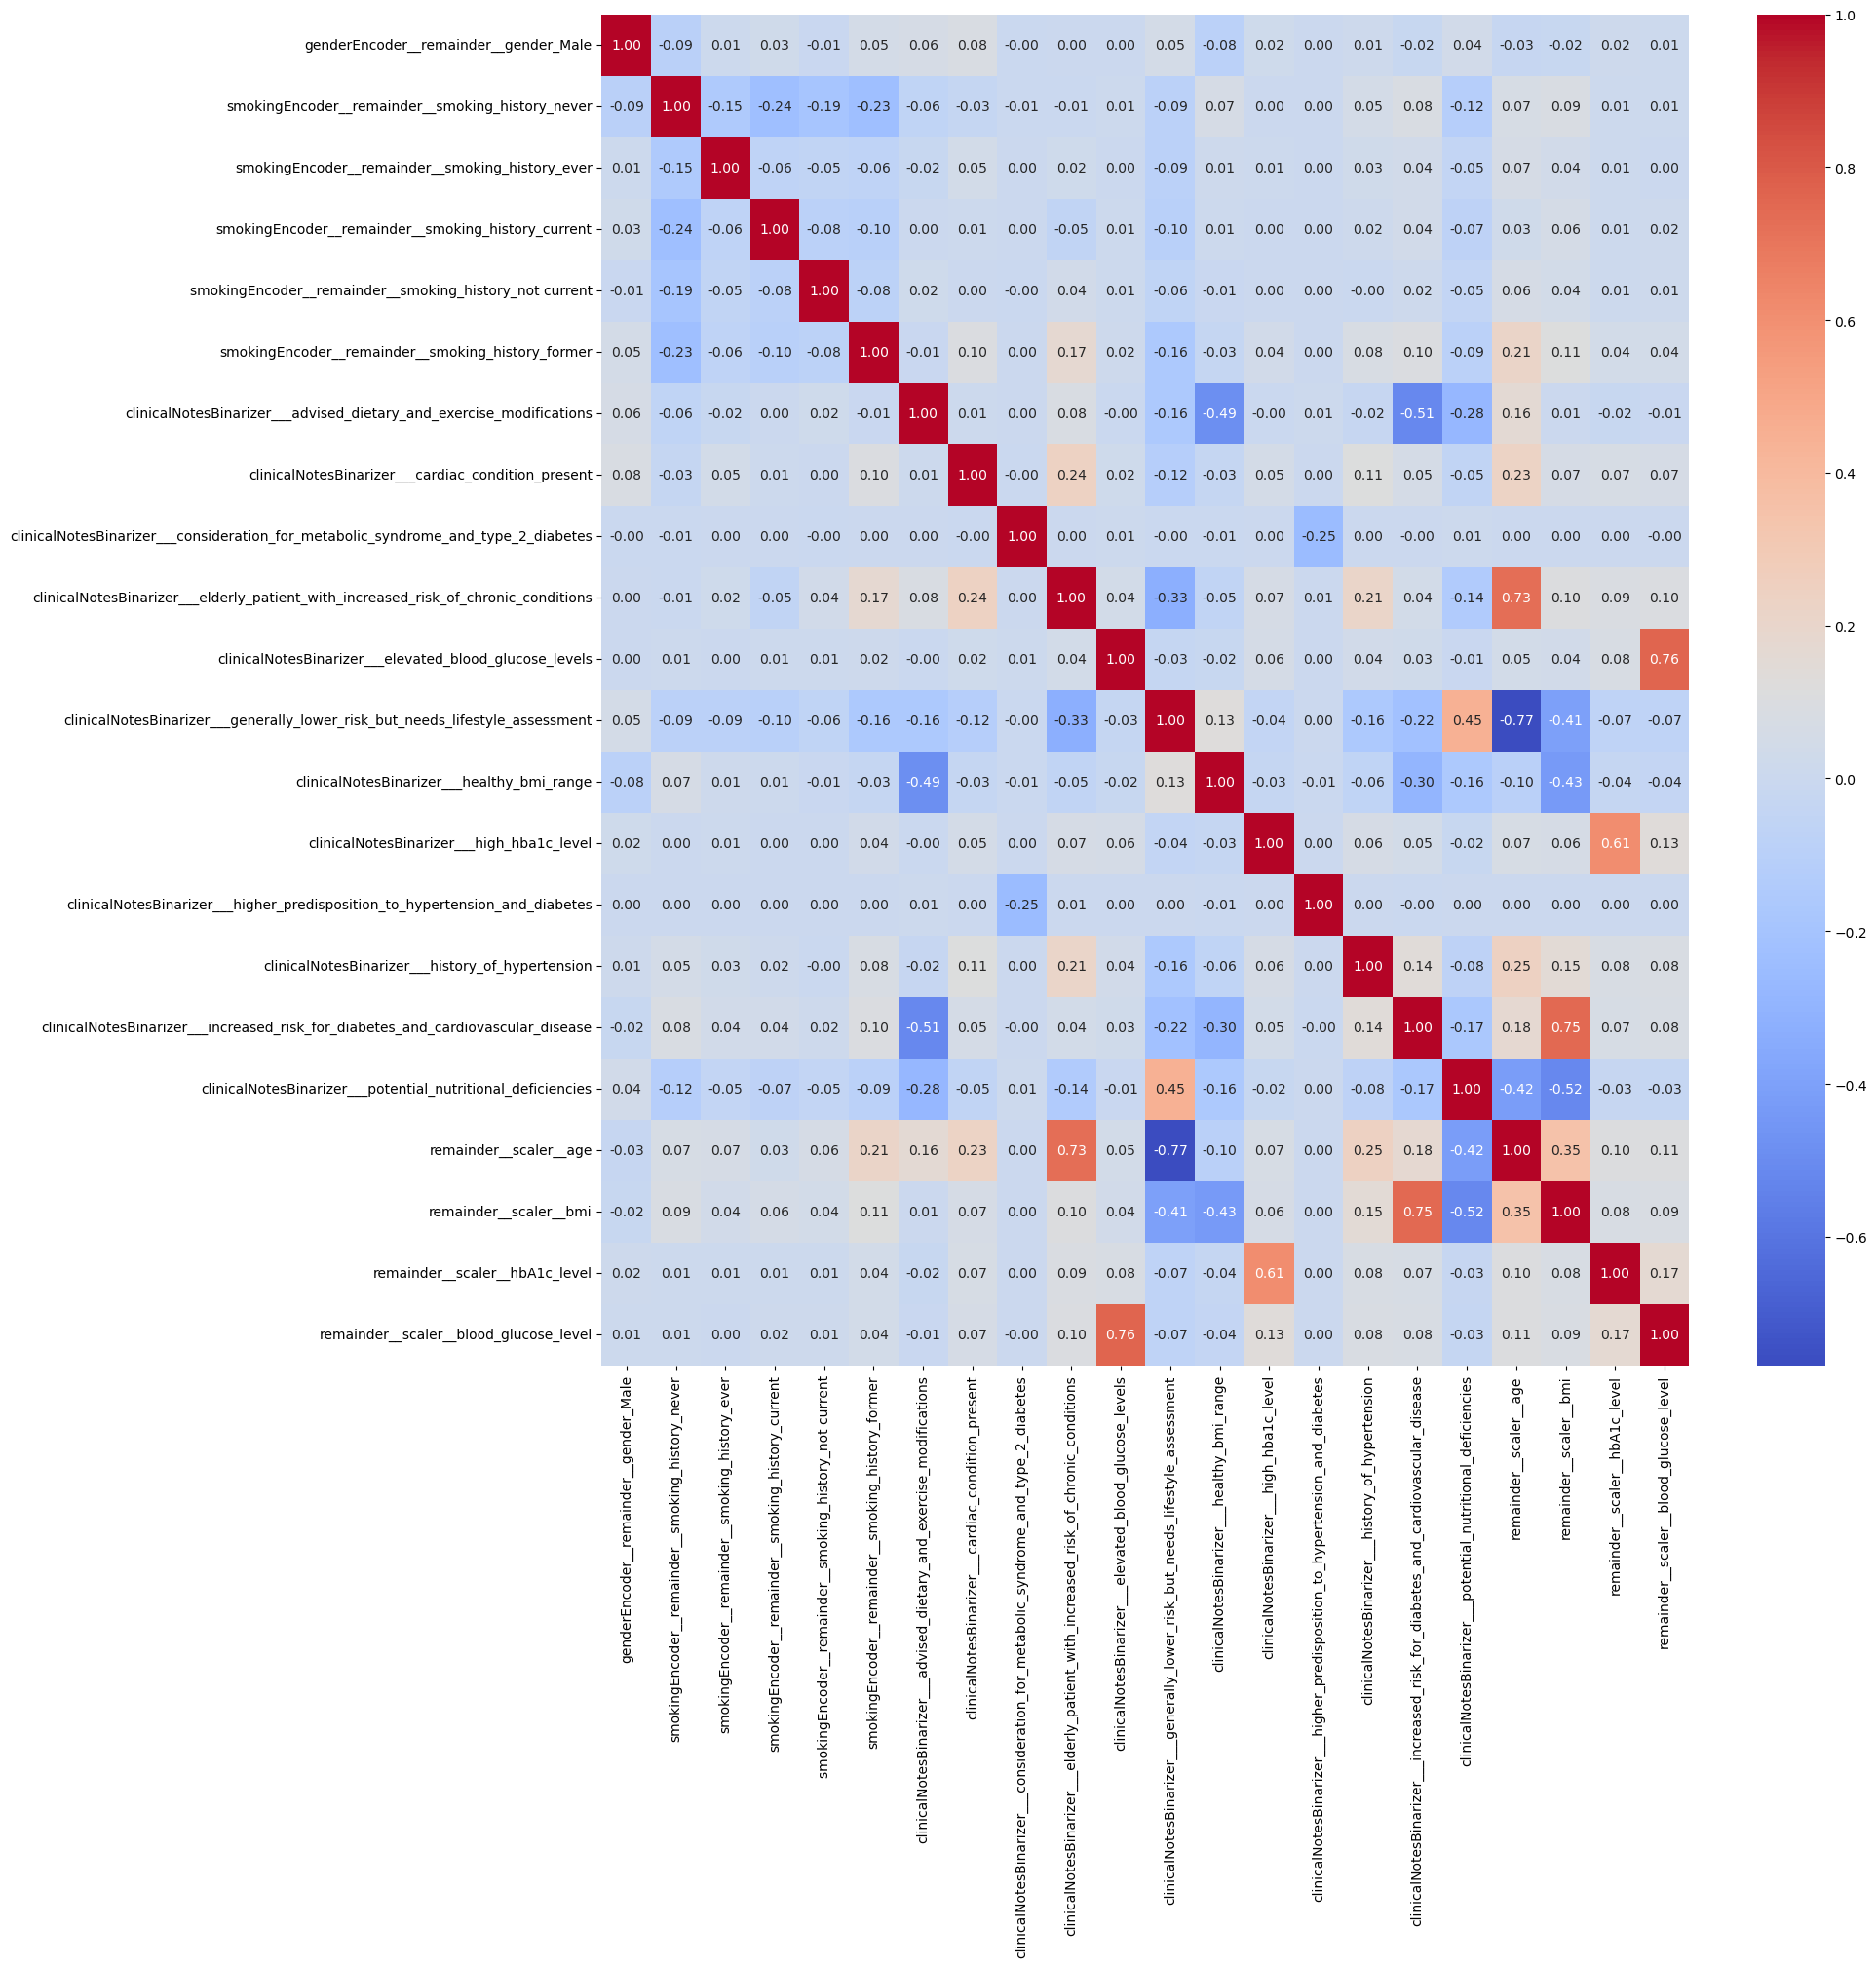

In [10]:
plt.figure(figsize=(18, 18))
sns.heatmap(X_train_transformed_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [198]:
def scores_model(X_train_transformed_df, X_test_transformed_df, model):
    model.fit(X_train_transformed_df, y_train)
    
    # Predictions and probabilities
    y_train_pred = model.predict(X_train_transformed_df)
    y_test_pred = model.predict(X_test_transformed_df)
    y_train_scores = model.predict_proba(X_train_transformed_df)[:, 1]  # Probabilities for training
    y_test_scores = model.predict_proba(X_test_transformed_df)[:, 1]   # Probabilities for test
    
    # Precision-Recall Curves
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
    
    # Evaluate the model
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    train_pr_auc = auc(recall_train, precision_train)  # PR-AUC for training
    test_pr_auc = auc(recall_test, precision_test)     # PR-AUC for test
    train_f1 = f1_score(y_train, y_train_pred)         # F1 score for training
    test_f1 = f1_score(y_test, y_test_pred)            # F1 score for test
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_prec = accuracy_score(y_train, y_train_pred)
    test_prec = accuracy_score(y_test, y_test_pred)
    cfm = confusion_matrix(y_test, y_test_pred)
    
    # Print results
    print("\nModel Performance:")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Training PR-AUC: {train_pr_auc:.4f}")
    print(f"Test PR-AUC: {test_pr_auc:.4f}")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Training Accuracy Score: {train_prec:.4f}")
    print(f"Test Accuracy Score: {test_prec:.4f}")
    print(f"Training Recall Score: {train_recall:.4f}")
    print(f"Test Recall Score: {test_recall:.4f}")
    print("Test Confusion Matrix:\n", cfm)
    disp = ConfusionMatrixDisplay(cfm)
    disp.plot()
    plt.show()
    return (train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc, train_f1, test_f1)


Model Performance:
Training ROC-AUC: 0.8108
Test ROC-AUC: 0.8130
Training PR-AUC: 0.8255
Test PR-AUC: 0.8310
Training F1 Score: 0.7359
Test F1 Score: 0.7387
Training Accuracy Score: 0.9616
Test Accuracy Score: 0.9619
Training Recall Score: 0.6291
Test Recall Score: 0.6336
Test Confusion Matrix:
 [[19069   146]
 [  654  1131]]


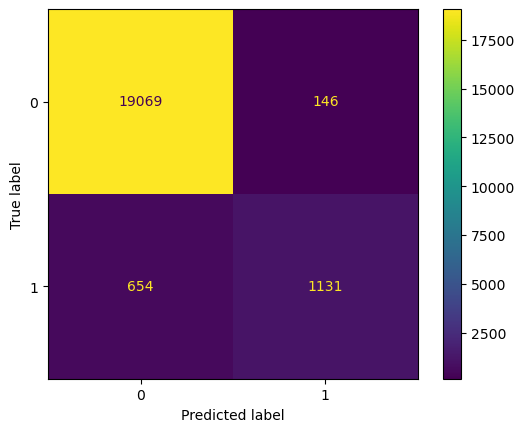

(0.810778737724598,
 0.8130076074145506,
 0.8254827428707748,
 0.8309939154416266,
 0.7358517062210364,
 0.7387328543435663)

In [221]:
model = LogisticRegression()
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training ROC-AUC: 0.8891
Test ROC-AUC: 0.8937
Training PR-AUC: 0.8233
Test PR-AUC: 0.8289
Training F1 Score: 0.5740
Test F1 Score: 0.5744
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8863
Training Recall Score: 0.8910
Test Recall Score: 0.9025
Test Confusion Matrix:
 [[17002  2213]
 [  174  1611]]


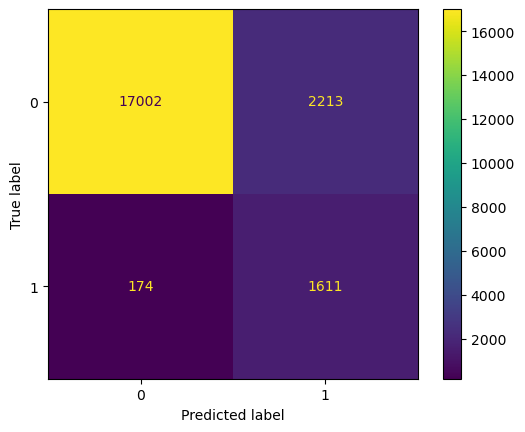

(0.8891248302599728,
 0.8936752843213788,
 0.8233054034123571,
 0.8289386583993921,
 0.5739695305854149,
 0.5744339454448208)

In [222]:
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, model)

In [223]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)

columns = X_train_transformed_df.columns.tolist()
selected_columns = np.array(columns)[sel.get_support()].tolist()

print("Selected features:", selected_columns)

Selected features: ['smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___history_of_hypertension', 'clinicalNotesBinarizer___increased_risk_for_diabetes_and_cardiovascular_disease', 'clinicalNotesBinarizer___potential_nutritional_deficiencies', 'remainder__scaler__age', 'remainder__scaler__bmi', 'remainder__scaler__hbA1c_level', 'remainder__scaler__blood_glucose_level']



Model Performance:
Training ROC-AUC: 0.8870
Test ROC-AUC: 0.8908
Training PR-AUC: 0.8199
Test PR-AUC: 0.8273
Training F1 Score: 0.5702
Test F1 Score: 0.5691
Training Accuracy Score: 0.8862
Test Accuracy Score: 0.8843
Training Recall Score: 0.8879
Test Recall Score: 0.8986
Test Confusion Matrix:
 [[16967  2248]
 [  181  1604]]


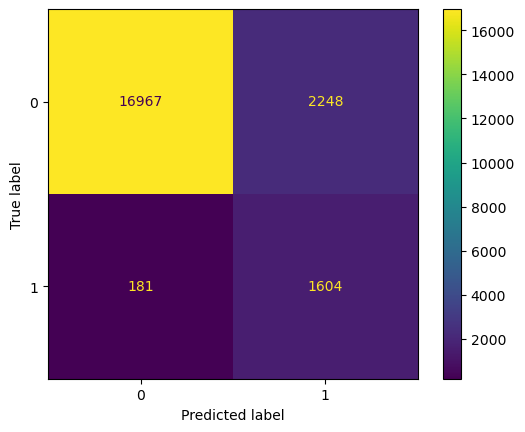

(0.8869843019174884,
 0.8908037531952671,
 0.8198885197689099,
 0.827260161369482,
 0.5702390131071704,
 0.5690970374312577)

In [224]:
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_sel, X_test_sel, model)


Model Performance:
Training ROC-AUC: 0.8888
Test ROC-AUC: 0.8935
Training PR-AUC: 0.8233
Test PR-AUC: 0.8290
Training F1 Score: 0.5734
Test F1 Score: 0.5739
Training Accuracy Score: 0.8874
Test Accuracy Score: 0.8861
Training Recall Score: 0.8905
Test Recall Score: 0.9025
Test Confusion Matrix:
 [[16997  2218]
 [  174  1611]]


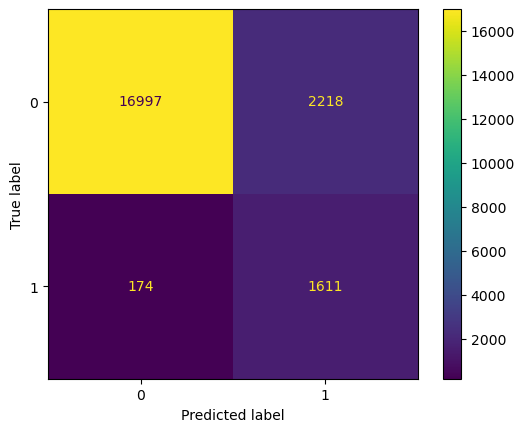

(0.8888066702090672,
 0.893545177633895,
 0.8233372151963988,
 0.8289903762234531,
 0.5734384662956091,
 0.5739223370146064)

In [225]:
model = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, model)

Fitting estimator with 22 features.


Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.

Model Performance:
Training ROC-AUC: 0.8886
Test ROC-AUC: 0.8933
Training PR-AUC: 0.8236
Test PR-AUC: 0.8293
Training F1 Score: 0.5740
Test F1 Score: 0.5739
Training Accuracy Score: 0.8878
Test Accuracy Score: 0.8861
Training Recall Score: 0.8896
Test Recall Score: 0.9020
Test Confusion Matrix:
 [[16999  2216]
 [  175  1610]]


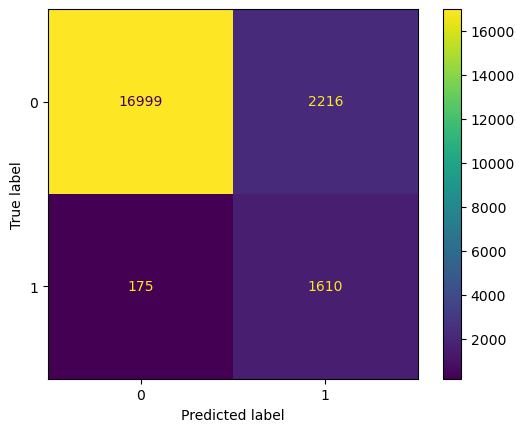

(0.8885718221714917,
 0.8933171082640706,
 0.8235525749428438,
 0.8293496009847602,
 0.5739736638264911,
 0.5738727499554447)

In [226]:
rfe = RFE(estimator = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced'), n_features_to_select=16, verbose=1)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)


Model Performance:
Training ROC-AUC: 0.8831
Test ROC-AUC: 0.8878
Training PR-AUC: 0.8148
Test PR-AUC: 0.8214
Training F1 Score: 0.5579
Test F1 Score: 0.5602
Training Accuracy Score: 0.8807
Test Accuracy Score: 0.8803
Training Recall Score: 0.8860
Test Recall Score: 0.8969
Test Confusion Matrix:
 [[16885  2330]
 [  184  1601]]


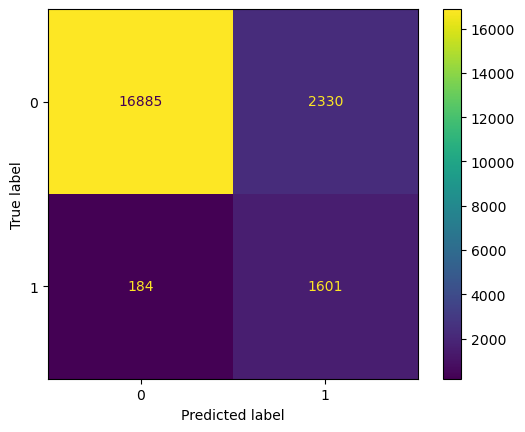

(0.883068637290982,
 0.88782966738608,
 0.8148046887663917,
 0.8214140922381276,
 0.5579496484463597,
 0.5601819454163751)

In [227]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_sel, X_test_sel, model)


The results with Variance Treshold are worse than only Logistic Regression

In [131]:
neighbors = np.arange(1,12)
train_roc_auc = {}
test_roc_auc = {}
train_f1 = {}
test_f1 = {}
train_pr_auc = {}
test_pr_auc = {}
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors = neighbor)
    train_roc_auc[neighbor], test_roc_auc[neighbor], train_pr_auc[neighbor], test_pr_auc[neighbor], train_f1[neighbor], test_f1[neighbor] = scores_model(X_train_transformed_df, X_test_transformed_df, knn)


Model Performance:
Training ROC-AUC: 0.9996
Test ROC-AUC: 0.8118
Training PR-AUC: 0.9992
Test PR-AUC: 0.6847
Training F1 Score: 0.9992
Test F1 Score: 0.6694
Test Confusion Matrix:
 [[18690   525]
 [  623  1162]]

Model Performance:
Training ROC-AUC: 0.8175
Test ROC-AUC: 0.7716
Training PR-AUC: 0.9584
Test PR-AUC: 0.7503
Training F1 Score: 0.7768
Test F1 Score: 0.6858
Test Confusion Matrix:
 [[19126    89]
 [  807   978]]

Model Performance:
Training ROC-AUC: 0.8521
Test ROC-AUC: 0.8009
Training PR-AUC: 0.9334
Test PR-AUC: 0.7728
Training F1 Score: 0.8048
Test F1 Score: 0.7035
Test Confusion Matrix:
 [[18980   235]
 [  689  1096]]

Model Performance:
Training ROC-AUC: 0.7944
Test ROC-AUC: 0.7731
Training PR-AUC: 0.9158
Test PR-AUC: 0.7837
Training F1 Score: 0.7348
Test F1 Score: 0.6913
Test Confusion Matrix:
 [[19141    74]
 [  803   982]]

Model Performance:
Training ROC-AUC: 0.8155
Test ROC-AUC: 0.7952
Training PR-AUC: 0.9042
Test PR-AUC: 0.7899
Training F1 Score: 0.7559
Test F1 Scor

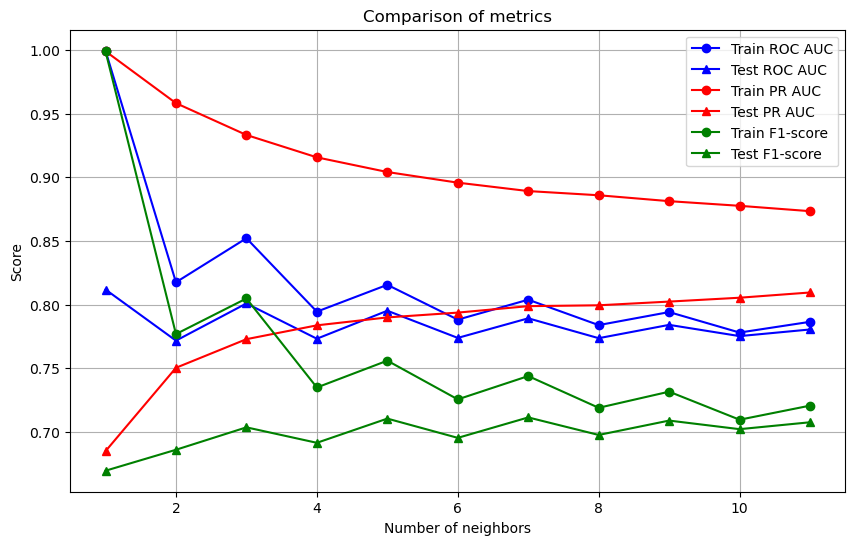

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(neighbors, train_roc_auc.values(), label="Train ROC AUC", marker='o', linestyle='-', color = 'blue')
plt.plot(neighbors, test_roc_auc.values(), label="Test ROC AUC", marker='^', linestyle='-', color = 'blue')

plt.plot(neighbors, train_pr_auc.values(), label="Train PR AUC", marker='o', linestyle='-', color = 'red')
plt.plot(neighbors, test_pr_auc.values(), label="Test PR AUC", marker='^', linestyle='-', color = 'red')

plt.plot(neighbors, train_f1.values(), label="Train F1-score", marker='o', linestyle='-', color = 'green')
plt.plot(neighbors, test_f1.values(), label="Test F1-score", marker='^', linestyle='-', color = 'green')

plt.xlabel("Number of neighbors")
plt.ylabel("Score")
plt.title("Comparison of metrics")
plt.legend()
plt.grid(True)

plt.show()

It seems that the best number of neighbors is 7.


Model Performance:
Training ROC-AUC: 0.8038
Test ROC-AUC: 0.7892
Training PR-AUC: 0.8892
Test PR-AUC: 0.7988
Training F1 Score: 0.7438
Test F1 Score: 0.7113
Training Accuracy Score: 0.9642
Test Accuracy Score: 0.9597
Training Recall Score: 0.6106
Test Recall Score: 0.5838
Test Confusion Matrix:
 [[19112   103]
 [  743  1042]]


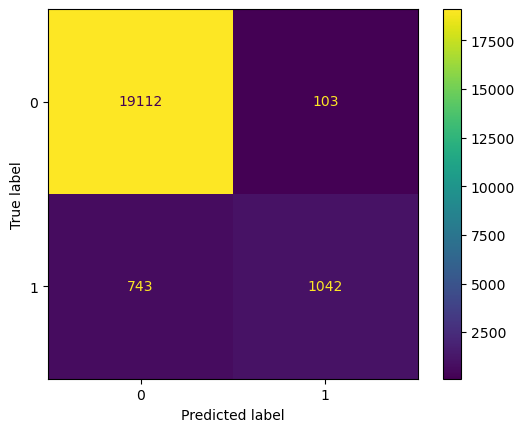

(0.8038323526131764,
 0.7891965529381152,
 0.8892429213467883,
 0.7987520894198481,
 0.7437847323778882,
 0.7112627986348122)

In [ ]:
model = KNeighborsClassifier(n_neighbors = 7)
scores_model(X_train_transformed_df, X_test_transformed_df, model)

RandomisedSearchCV for DecisionTreeClassifier

Best parameters: {'min_samples_split': 4, 'min_samples_leaf': 0.05, 'max_features': 4, 'max_depth': 13, 'criterion': 'entropy'}

Best model scores:

Model Performance:
Training ROC-AUC: 0.8113
Test ROC-AUC: 0.8134
Training PR-AUC: 0.4964
Test PR-AUC: 0.4943
Training F1 Score: 0.3746
Test F1 Score: 0.3753
Training Accuracy Score: 0.7482
Test Accuracy Score: 0.7473
Training Recall Score: 0.8874
Test Recall Score: 0.8930
Test Confusion Matrix:
 [[14100  5115]
 [  191  1594]]


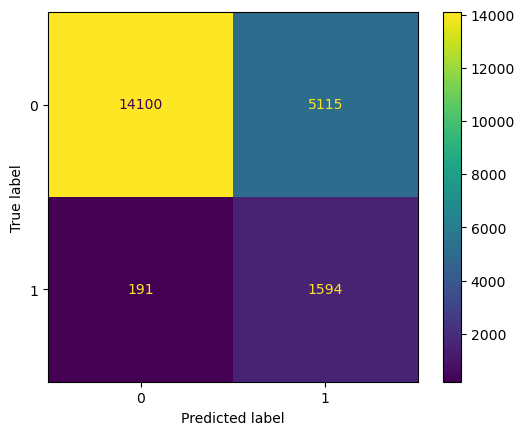

(0.8113120658099305,
 0.8133994581439132,
 0.4964415476930305,
 0.49427173068749664,
 0.3746199067504561,
 0.37532375794678596)

In [220]:
def pr_auc_scorer(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)
    
param_dist = {
    "max_depth" : range(2, 20),
    "max_features" : range(2, 10),
    "min_samples_split" : range(2, 20),
    'min_samples_leaf': [0.05, 0.1, 0.15, 0.2],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(class_weight='balanced')
scoring = {
    'roc_auc': 'roc_auc', 
    'f1_score': 'f1',  
    'pr_auc': make_scorer(pr_auc_scorer),
    'recall': 'recall' 
}

random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scoring, random_state=42, n_jobs=-1, refit='recall')

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model)


Model Performance:
Training ROC-AUC: 0.8083
Test ROC-AUC: 0.8074
Training PR-AUC: 0.5127
Test PR-AUC: 0.5049
Training F1 Score: 0.3717
Test F1 Score: 0.3724
Training Accuracy Score: 0.7462
Test Accuracy Score: 0.7484
Training Recall Score: 0.8831
Test Recall Score: 0.8784
Test Confusion Matrix:
 [[14148  5067]
 [  217  1568]]


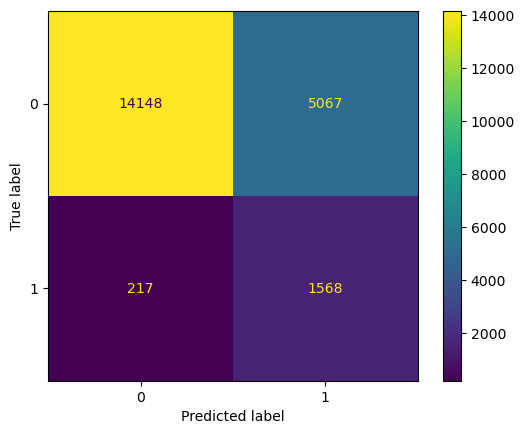

In [228]:
lr = LogisticRegression(class_weight='balanced')

knn = KNeighborsClassifier(n_neighbors=9)

dt = DecisionTreeClassifier(max_depth = 15, min_samples_leaf=0.1, random_state=2, max_features = 15, class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, dt)

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

Voting Classifier

Logistic Regression

Model Performance:
Training ROC-AUC: 0.8891
Test ROC-AUC: 0.8937
Training PR-AUC: 0.8233
Test PR-AUC: 0.8289
Training F1 Score: 0.5740
Test F1 Score: 0.5744
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8863
Training Recall Score: 0.8910
Test Recall Score: 0.9025
Test Confusion Matrix:
 [[17002  2213]
 [  174  1611]]


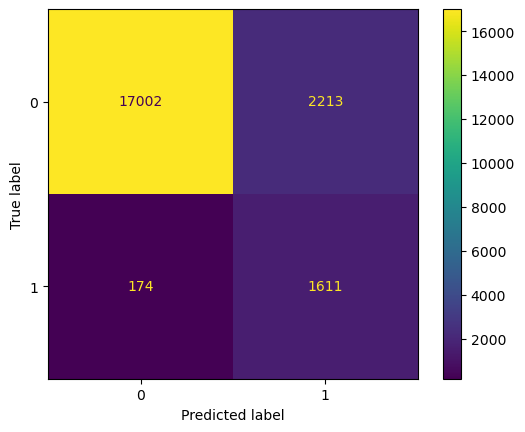

K Nearest Neighbours

Model Performance:
Training ROC-AUC: 0.7941
Test ROC-AUC: 0.7840
Training PR-AUC: 0.8813
Test PR-AUC: 0.8023
Training F1 Score: 0.7315
Test F1 Score: 0.7088
Training Accuracy Score: 0.9632
Test Accuracy Score: 0.9600
Training Recall Score: 0.5904
Test Recall Score: 0.5720
Test Confusion Matrix:
 [[19140    75]
 [  764  1021]]


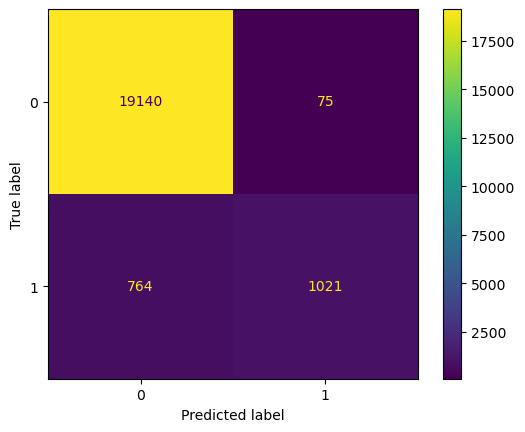

Classification Tree

Model Performance:
Training ROC-AUC: 0.8083
Test ROC-AUC: 0.8074
Training PR-AUC: 0.5127
Test PR-AUC: 0.5049
Training F1 Score: 0.3717
Test F1 Score: 0.3724
Training Accuracy Score: 0.7462
Test Accuracy Score: 0.7484
Training Recall Score: 0.8831
Test Recall Score: 0.8784
Test Confusion Matrix:
 [[14148  5067]
 [  217  1568]]


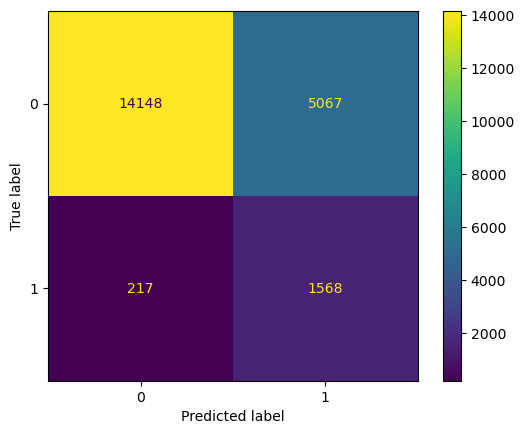

Voting classifier:

Model Performance:
Training ROC-AUC: 0.8914
Test ROC-AUC: 0.8812
Training PR-AUC: 0.8488
Test PR-AUC: 0.8250
Training F1 Score: 0.6756
Test F1 Score: 0.6613
Training Accuracy Score: 0.9312
Test Accuracy Score: 0.9282
Training Recall Score: 0.8435
Test Recall Score: 0.8246
Test Confusion Matrix:
 [[18020  1195]
 [  313  1472]]


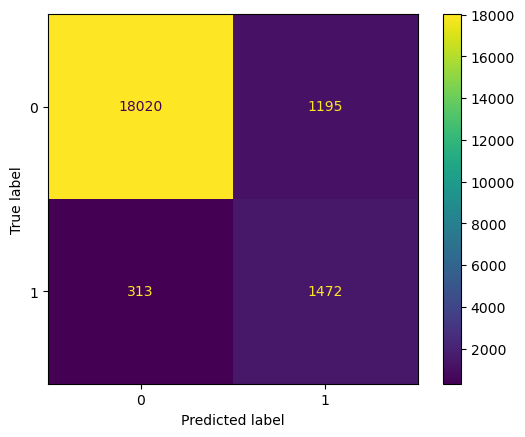

(0.8913840946214552,
 0.8812294316633756,
 0.8488106928380809,
 0.8249784431182627,
 0.6756418886431388,
 0.6612758310871518)

In [229]:
for clf_name, model in classifiers:    
    print(clf_name)
    scores_model(X_train_transformed_df, X_test_transformed_df, model)
vc = VotingClassifier(estimators=classifiers, voting='soft') 
print('Voting classifier:')
scores_model(X_train_transformed_df, X_test_transformed_df, vc)

Random Forest Classifier


Model Performance:
Training ROC-AUC: 0.9373
Test ROC-AUC: 0.9006
Training PR-AUC: 0.9293
Test PR-AUC: 0.8769
Training F1 Score: 0.7086
Test F1 Score: 0.6588
Training Accuracy Score: 0.9342
Test Accuracy Score: 0.9231
Training Recall Score: 0.9409
Test Recall Score: 0.8734
Test Confusion Matrix:
 [[17826  1389]
 [  226  1559]]


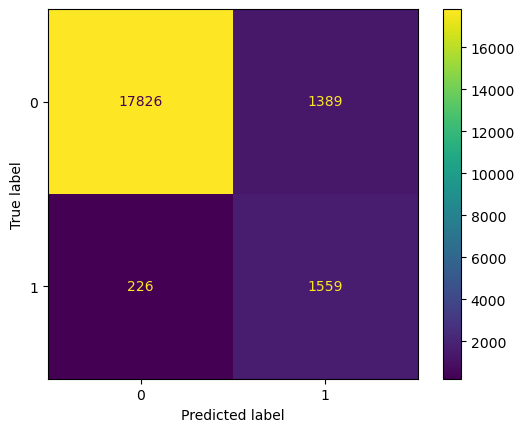

(0.9372686779629883,
 0.9005510400881664,
 0.9292693001818166,
 0.8769463936425056,
 0.7086158575174035,
 0.6587787872385379)

In [234]:
rf = RandomForestClassifier(max_depth=13, class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, rf)


Model Performance:
Training ROC-AUC: 0.9338
Test ROC-AUC: 0.8994
Training PR-AUC: 0.9272
Test PR-AUC: 0.8780
Training F1 Score: 0.7010
Test F1 Score: 0.6550
Training Accuracy Score: 0.9321
Test Accuracy Score: 0.9219
Training Recall Score: 0.9359
Test Recall Score: 0.8723
Test Confusion Matrix:
 [[17803  1412]
 [  228  1557]]


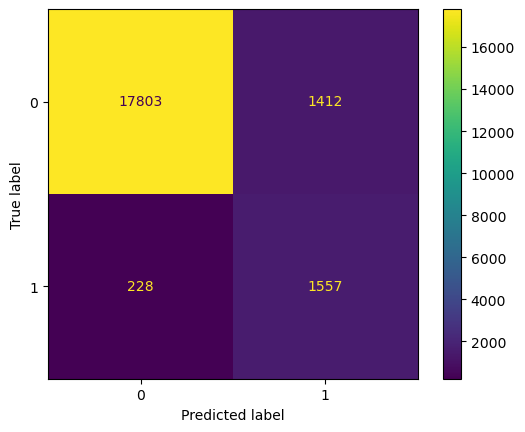

(0.9338332054133128,
 0.8993923252361053,
 0.9272040442097857,
 0.8780153896077352,
 0.7009530659953246,
 0.6550273453933529)

In [231]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training ROC-AUC: 0.9402
Test ROC-AUC: 0.8995
Training PR-AUC: 0.9322
Test PR-AUC: 0.8760
Training F1 Score: 0.7269
Test F1 Score: 0.6741
Training Accuracy Score: 0.9399
Test Accuracy Score: 0.9290
Training Recall Score: 0.9405
Test Recall Score: 0.8639
Test Confusion Matrix:
 [[17967  1248]
 [  243  1542]]


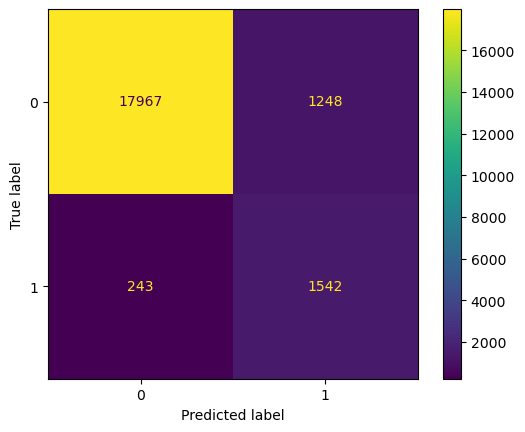

(0.9401734464277516,
 0.8994581439133029,
 0.9321863729817885,
 0.8759810077701815,
 0.7269184374130092,
 0.6740983606557377)

In [232]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training ROC-AUC: 0.9375
Test ROC-AUC: 0.9020
Training PR-AUC: 0.9274
Test PR-AUC: 0.8790
Training F1 Score: 0.7075
Test F1 Score: 0.6602
Training Accuracy Score: 0.9338
Test Accuracy Score: 0.9233
Training Recall Score: 0.9419
Test Recall Score: 0.8762
Test Confusion Matrix:
 [[17826  1389]
 [  221  1564]]


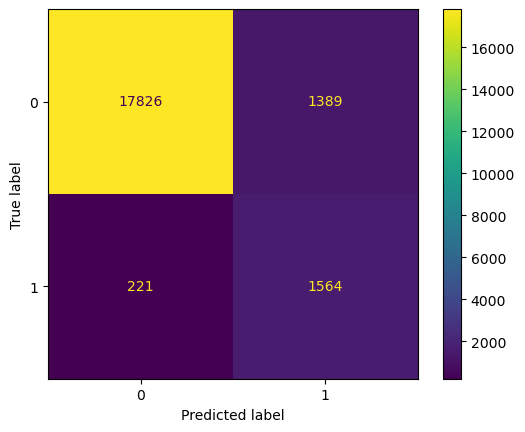

[0.00469373 0.00337071 0.00216132 0.00275016 0.00258294 0.00431827
 0.00421842 0.01016991 0.00342597 0.03525622 0.05550553 0.0346893
 0.00521032 0.09163023 0.00310939 0.01674124 0.02083068 0.0030256
 0.1192456  0.05338565 0.29575099 0.22792783]

Model Performance:
Training ROC-AUC: 0.9214
Test ROC-AUC: 0.8965
Training PR-AUC: 0.8923
Test PR-AUC: 0.8603
Training F1 Score: 0.6326
Test F1 Score: 0.5985
Training Accuracy Score: 0.9074
Test Accuracy Score: 0.8980
Training Recall Score: 0.9383
Test Recall Score: 0.8947
Test Confusion Matrix:
 [[17260  1955]
 [  188  1597]]


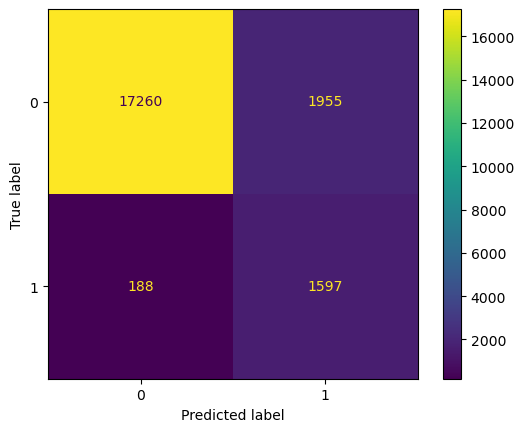

(0.9213947874231659,
 0.8964672207680886,
 0.8923166352107401,
 0.8602607105341755,
 0.6326183731282882,
 0.5984635563050403)

In [235]:
scores_model(X_train_transformed_df, X_test_transformed_df, rf)
print(rf.feature_importances_)
mask = rf.feature_importances_ > 0.06
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)

Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.

Model Performance:
Training ROC-AUC: 0.9408
Test ROC-AUC: 0.9007
Training PR-AUC: 0.9296
Test PR-AUC: 0.8781
Training F1 Score: 0.7226
Test F1 Score: 0.6684
Training Accuracy Score: 0.9384
Test Accuracy Score: 0.9267
Training Recall Score: 0.9436
Test Recall Score: 0.8695
Test Confusion Matrix:
 [[17908  1307]
 [  233  1552]]


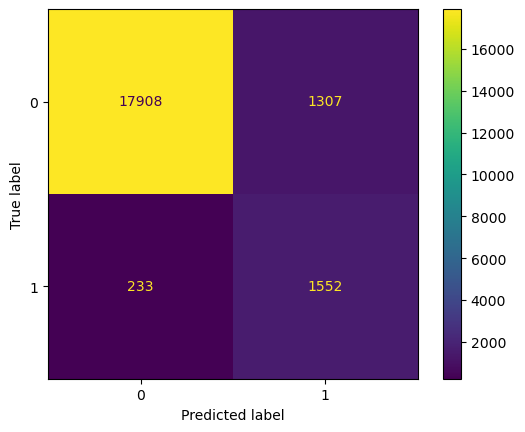

(0.9407638465222155,
 0.9007240054491742,
 0.9295710743873787,
 0.878078533975699,
 0.7226257240047808,
 0.6683893195521102)

In [236]:
rfe = RFE(estimator=rf, n_features_to_select=8, verbose=1, step=5)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)

[0.26026325 0.43996261 0.5796008  0.70175682 0.75437267 0.79355488
 0.82689059 0.85720648 0.87952059 0.89768802 0.91357461 0.92823281
 0.94141713 0.9541003  0.96523757 0.97465769 0.98210941 0.98733193
 0.99207206 0.99633129 1.         1.        ]


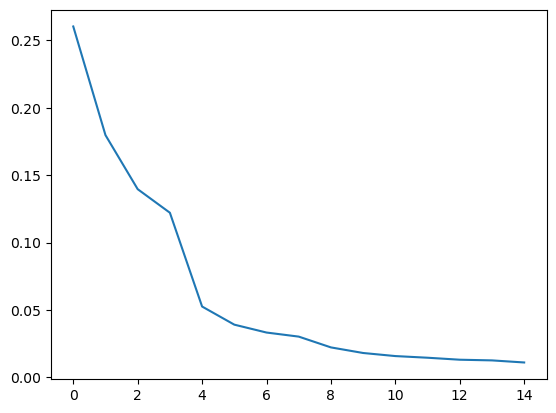

In [237]:
pipelinePCA = Pipeline([
    ('reducer', PCA(n_components=15)),
    ('classifier', rf)
])
pca = PCA()
pca.fit_transform(X_train_transformed_df, y_train)
print(pca.explained_variance_ratio_.cumsum())
pipelinePCA.fit(X_train_transformed, y_train)
plt.plot(pipelinePCA['reducer'].explained_variance_ratio_)


Model Performance:
Training ROC-AUC: 0.9537
Test ROC-AUC: 0.8901
Training PR-AUC: 0.9367
Test PR-AUC: 0.8589
Training F1 Score: 0.7723
Test F1 Score: 0.6811
Training Accuracy Score: 0.9521
Test Accuracy Score: 0.9333
Training Recall Score: 0.9556
Test Recall Score: 0.8381
Test Confusion Matrix:
 [[18103  1112]
 [  289  1496]]


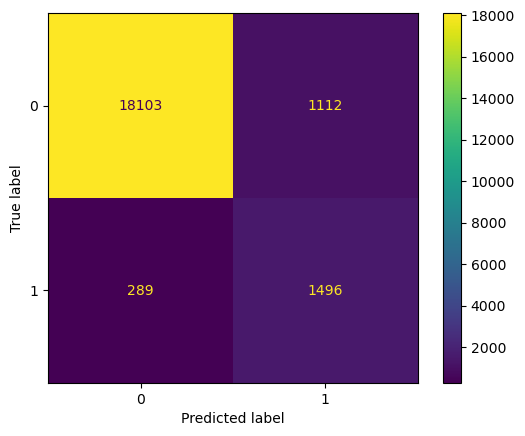

(0.9536804885888781,
 0.8901118917512361,
 0.9367402420085833,
 0.8589307163211245,
 0.7722906762394489,
 0.6810835419986342)

In [238]:
pipelinePCA2 = Pipeline([
    ('reducer', PCA(n_components=5)),
    ('classifier', rf)
])
scores_model(X_train_transformed_df, X_test_transformed_df, pipelinePCA2)

Best parameters: {'n_estimators': 42, 'min_samples_split': 12, 'max_features': 5, 'max_depth': 7}

Best model scores:

Model Performance:
Training ROC-AUC: 0.9053
Test ROC-AUC: 0.9056
Training PR-AUC: 0.8719
Test PR-AUC: 0.8787
Training F1 Score: 0.5912
Test F1 Score: 0.5909
Training Accuracy Score: 0.8917
Test Accuracy Score: 0.8914
Training Recall Score: 0.9217
Test Recall Score: 0.9227
Test Confusion Matrix:
 [[17072  2143]
 [  138  1647]]


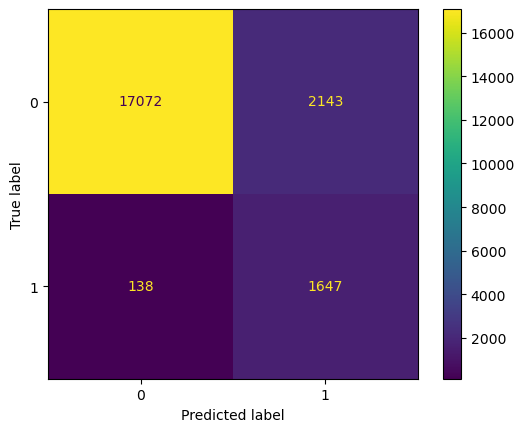

(0.9052939208470274,
 0.9055808115595966,
 0.8719078489432773,
 0.8786769496791904,
 0.5912065912065912,
 0.5908520179372198)

In [239]:
param_dist = {"max_depth" : range(2, 20),
              "max_features" : range(2, 10),
              "min_samples_split" : range(2, 20),
              "n_estimators" : range(2, 100, 10)}

scorer = make_scorer(recall_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer)

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

best_model = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model)


Model Performance:
Training ROC-AUC: 0.9045
Test ROC-AUC: 0.9063
Training PR-AUC: 0.8727
Test PR-AUC: 0.8798
Training F1 Score: 0.5922
Test F1 Score: 0.5920
Training Accuracy Score: 0.8924
Test Accuracy Score: 0.8918
Training Recall Score: 0.9191
Test Recall Score: 0.9238
Test Confusion Matrix:
 [[17078  2137]
 [  136  1649]]


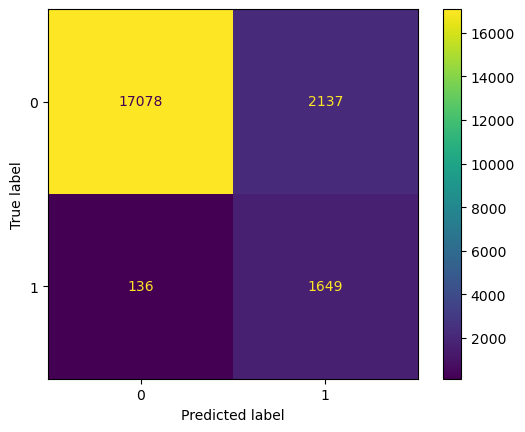

(0.9045198407231745,
 0.9062971636742129,
 0.8727232115189559,
 0.8798156255236824,
 0.5922487816198654,
 0.5919942559684078)

In [240]:
clf = BaggingClassifier(estimator=best_model,
                        n_estimators=15)
scores_model(X_train_transformed_df, X_test_transformed_df, clf)


Model Performance:
Training ROC-AUC: 0.8319
Test ROC-AUC: 0.8465
Training PR-AUC: 0.8679
Test PR-AUC: 0.8773
Training F1 Score: 0.7980
Test F1 Score: 0.8187
Training Accuracy Score: 0.9714
Test Accuracy Score: 0.9739
Test Confusion Matrix:
 [[19215     0]
 [  548  1237]]


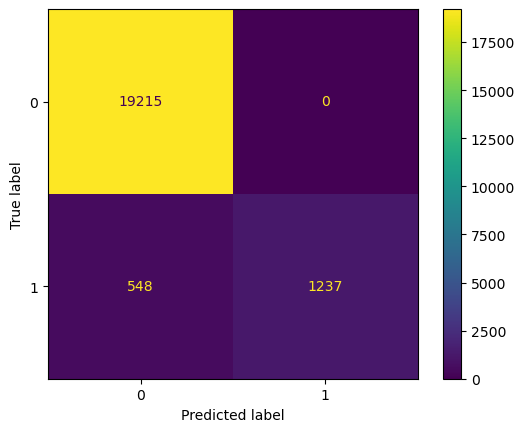

(0.8319327731092436,
 0.8464985994397759,
 0.8679404059139555,
 0.8773173872150284,
 0.797979797979798,
 0.8186631369953673)

In [ ]:
ada = AdaBoostClassifier()
scores_model(X_train_transformed_df, X_test_transformed_df, ada)